In [26]:

from settings import MOTIONS_FILE_PATH, MOTIONS_FILE_PATH_LOCK, MOTIONS_FOLDER
import json
import pandas as pd
from Tracker.Motion import Motion
import os

with MOTIONS_FILE_PATH_LOCK:
    with open(MOTIONS_FILE_PATH, "r") as f:
        motions_header = json.load(f)


labeled_motions: dict = {

}

for motion_header in motions_header["stored_motions"]:
    new_motion = Motion.from_file(os.path.join(MOTIONS_FOLDER, motion_header["id"]))
    if new_motion is None:
        print("Failed to open motion")
        exit(0)
    
    labeled_motions[motion_header["label"]] = labeled_motions.get(motion_header["label"], [])

    for shape in motion_header["shapes_acce"]:
        streams = new_motion.as_linear()
        labeled_motions[motion_header["label"]].append(
            [stream[shape["start"]:shape["end"]] for stream in streams])

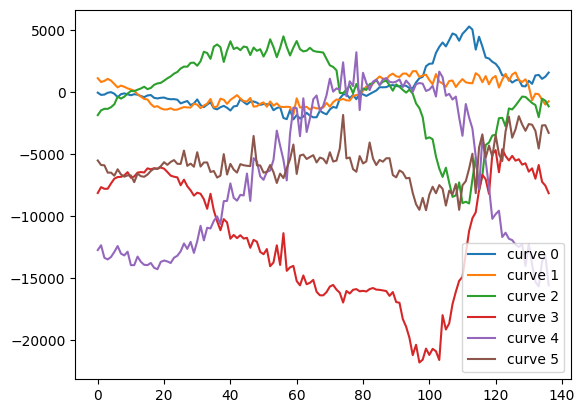

In [27]:
import matplotlib.pyplot as plt 
import numpy as np 
for streams in labeled_motions["bicep-curl-right"]:
    for i,stream in enumerate( streams):
        plt.plot(stream, label = f"curve {i}") 
    plt.legend() 
    plt.show()
    break

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import os
from matplotlib import rc, rcParams, colors, animation


def set_fig_style(fig, font_size=22, bg_color_html="#f9fafb"):
    if bg_color_html is not None:
        blog_color = (249/255, 250/255, 251/255, 255/255)
        fig.patch.set_facecolor(blog_color)
        for ax in fig.axes:
            ax.set_facecolor(blog_color)
    rcParams.update({
        'text.latex.preamble': r'\usepackage{newtxmath}',
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "New Century Schoolbook", "Bookman", "Computer Modern Roman"],
        "font.size": font_size
    })
    rc('text', usetex=True)


def export_animation(anim, fname, ext=None, fps=5, dpi=200):
    if ext is None:
        # If ext is None, all GIF+video figures are generated
        for ext in ["gif", "mp4", "webm"]:
            export_animation(anim, fname, ext=ext)
    fname_with_ext = f"{fname}.{ext}"
    if ext == "gif":
        anim.save(fname_with_ext, dpi=dpi, savefig_kwargs={'pad_inches': 'tight'})
    elif ext == "html":
        rcParams["animation.frame_format"] = "svg"
        html_widget = anim.to_jshtml(default_mode="loop")
        open(fname_with_ext, "w").write(html_widget)  # Generated files are huge...
    elif ext in ["mp4", "webm"]:
        Writer = animation.writers['ffmpeg']
        if ext == "mp4":
            writer = Writer(fps=fps, codec="libx265")
        else:
            writer = Writer(fps=fps, codec='libvpx-vp9')
        anim.save(fname_with_ext, writer=writer, dpi=dpi)
    else:
        print(f"Unrecognized extension: {ext}")

shift = 15
length = 60


np.random.seed(0)
def plot_animation(X_train,path):
    def animate(i):
        for j in range(len(X_train)):
            if j < i:
                lines[j].set_alpha(lines[j].get_alpha() * .7)
            elif i == j:
                lines[j].set_alpha(1.)
            else:
                lines[j].set_alpha(0.)

        return lines

    fig, ax = plt.s()
    set_fig_style(fig, font_size=14)
    colors = sns.color_palette("Paired")
    lines = []
    for i in range(len(X_train)):
        line_ts, = ax.plot(X_train[i], color=colors[7], linestyle='-', 
                        alpha=1. if i == 0 else 0.)
        lines.append(line_ts)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()

    ani = animation.FuncAnimation(fig, animate, interval=200, blit=True, save_count=len(X_train))
    export_animation(ani, path,ext="gif")


In [41]:
import numpy as np
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import random
window_length = 11
polyorder = 3
m = max([len(streams[0]) for streams in labeled_motions["bicep-curl-right"]])
all_streams = []
for k,value in enumerate(labeled_motions.values()):
    streams = [
        [],
        [],
        [],
        [],
        [],
        [],
        ] 
    for i in range(6):
        for stream in value:    
            if len(stream[i]) == 0:
                continue

            # Apply Savitzky-Golay filter
            #filtered_stream = savgol_filter(stream[i], window_length, polyorder)

            # Interpolate to size m
            if len(stream[i]) < m:
                f = interp1d(np.linspace(0, 1, len(stream[i])), stream[i], kind='linear')  # Choose interpolation kind as needed
                interpolated_stream = f(np.linspace(0, 1, m))
            else:
                interpolated_stream = stream[i][:m]  # Truncate if longer

            streams[i].append(interpolated_stream)
    all_streams.append(streams)
        

In [43]:
print(len(all_streams))

2


In [50]:
from tslearn.barycenters.dba import dtw_barycenter_averaging



In [9]:
from MotionRecognition.tools import load_data,preprocess

data = load_data(preprocess=preprocess,interpolation_size=140)

In [10]:
training_data = [
    [],
    [],
    [],
    [],
    [],
    [],
]
import random
for i in range(6):
    for stream in data.values():
        training_data[i].extend(stream[i])
    random.shuffle(training_data[i])


In [11]:
from tslearn.clustering import TimeSeriesKMeans
import seaborn as sns
import numpy as np
colors = sns.color_palette("Paired")
nb_clusters = 2
answers = []
i = 0
for stream in training_data:
    dba_km = TimeSeriesKMeans(n_clusters=nb_clusters ,
                            metric="dtw",
                            verbose=False,
                            random_state=0)
    y_pred = dba_km.fit_predict(stream)
    answers.append(y_pred)
    for cluster in range(nb_clusters):
        
        
        for xx in np.array(stream)[y_pred == cluster]:
            plt.plot(xx.ravel(), alpha=.1, color="000000") 
        plt.plot(dba_km.cluster_centers_[cluster].ravel(), label = f"Centroid", color=colors[7], linestyle="-") 
        
        plt.legend() 
        plt.show()
    
    i += 1
    print("------------------------------------------------------------------------------------")
    
    dba_km.predict(X=stream[0])

NameError: name 'np' is not defined

In [ ]:
real_answers = np.array( [streams[1] for streams in filtered_data])


for answer in answers:
    
    score = np.sum(answer == real_answers) / len(real_answers)
    print(score)


"""
0.7412587412587412
0.972027972027972
1.0
1.0
0.965034965034965
1.0
"""

0.7692307692307693
0.9370629370629371
1.0
1.0
0.9230769230769231
1.0


'\n0.7412587412587412\n0.972027972027972\n1.0\n1.0\n0.965034965034965\n1.0\n'

In [4]:
from MotionRecognition.tools import generate_centroids

centroids = generate_centroids()

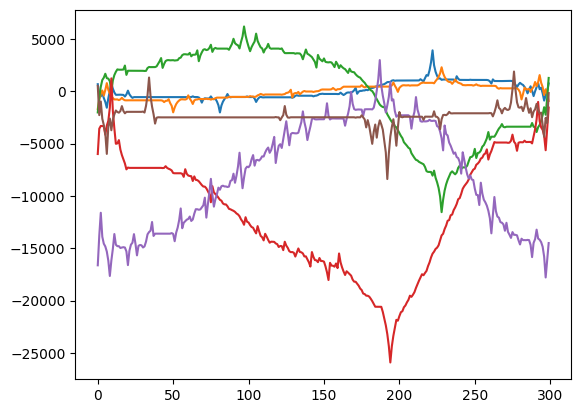

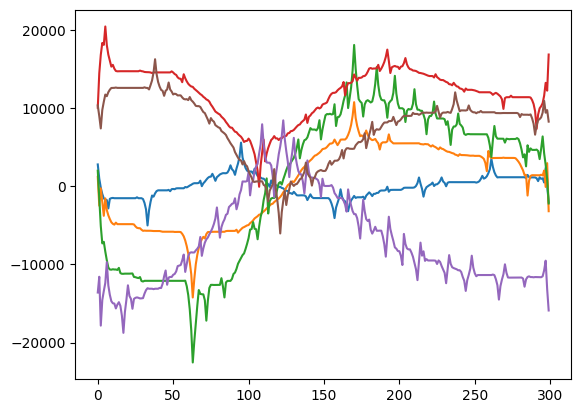

In [7]:
import matplotlib.pyplot as plt
for key,value in centroids.items():
    for stream in value:
        plt.plot(stream)
    plt.show()
    


In [3]:
from MotionRecognition.tools import load_data, preprocess
import random
import numpy as np
interpolation_size = 140
data = load_data(preprocess=preprocess, interpolation_size=interpolation_size)
training_data = [
    [],
    [],
    [],
    [],
    [],
    [],
]

test_data = [
]

for key, streams in data.items():
    for i in range(65, len(streams[0])):
        curr_streams = [streams[j][i] for j in range(6)]
        test_data.append((np.array(curr_streams),key))

for i in range(6):
    for stream in data.values():

        training_data[i].extend(stream[i][:65])
    random.shuffle(training_data[i])

In [7]:



for centroid in centroids:
    for stream in centroid:
        plt.plot(stream)
    plt.show()

ValueError: could not broadcast input array from shape (140,1) into shape (1,140)

In [24]:
len(a)

6

In [18]:
from MotionRecognition.MotionRecognition import MotionRecognitionKMEANS,MotionRecognitionDTW
from tslearn.barycenters.dba import dtw_barycenter_averaging
kmeans = MotionRecognitionKMEANS(train_data=training_data,sliding_window_size=interpolation_size)

dtw = MotionRecognitionDTW(centroids="asd", sliding_window_size=interpolation_size)
 

In [19]:
def most_repeated_value(arr):
    counts = {}
    for num in arr:
        if num in counts:
            counts[num] += 1
        else:
            counts[num] = 1
    
    # Find the element with the maximum count
    most_common_element = max(counts, key=counts.get)
    
    return most_common_element

results = {
    
}

for test,test_res in test_data:
    results[test_res] = results.get(test_res,[])
    
    kmeans.slide_window(test)
    res = kmeans.cmpr()
    results[test_res].append(most_repeated_value([r[0] for r in res]))
print(results)

{'bicep-curl-right': [0, 0, 0, 0, 0, 0], 'shoulder-fly-r': [1, 1, 1, 1, 1, 1, 1]}


# Motion recognition dtw

In [1]:
from MotionRecognition.tools import load_data, preprocess
from tslearn.barycenters.dba import dtw_barycenter_averaging

import numpy as np
interpolation_size = 140
data = load_data(preprocess=preprocess, interpolation_size=interpolation_size)
test_data = [
]

for key, streams in data.items():
    for i in range(65, len(streams[0])):
        curr_streams = [streams[j][i] for j in range(6)]
        test_data.append((np.array(curr_streams), key))

centroids = {}

for i in range(6):
    for key, stream in data.items():
        centroids[key] = centroids.get(key, [[], [], [], [], [], []])
        centroids[key][i] = dtw_barycenter_averaging(stream[i][:65])

bicep-curl-right


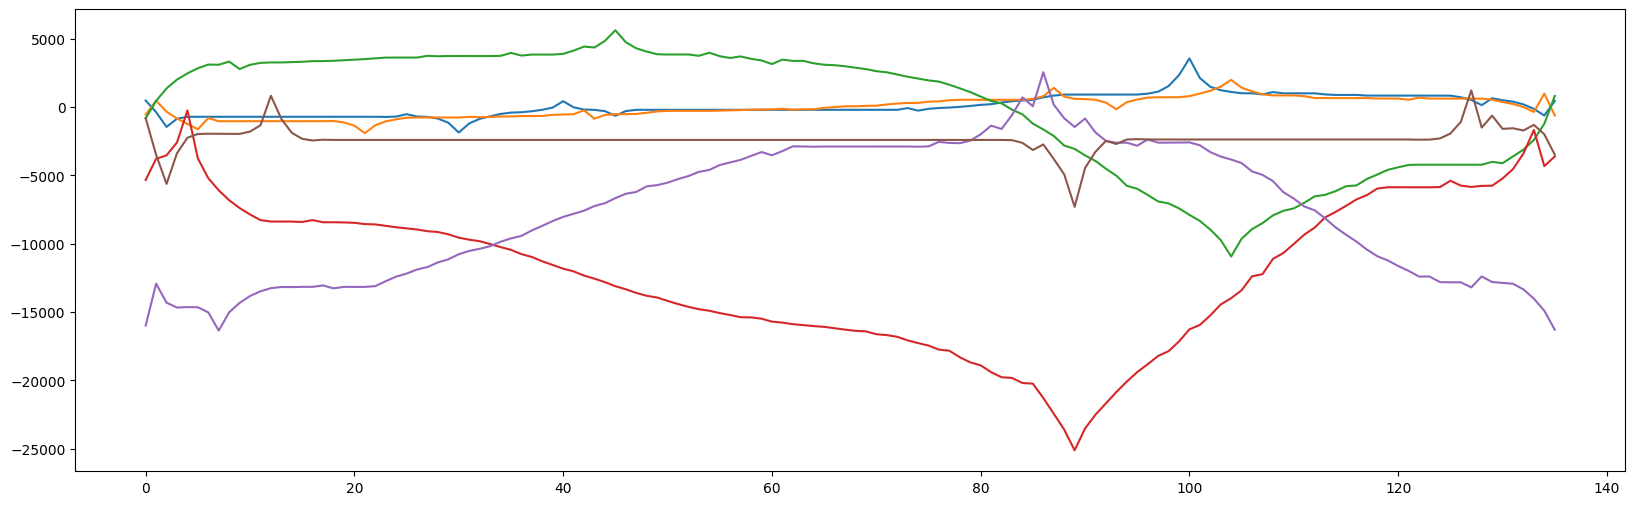

shoulder-fly-r


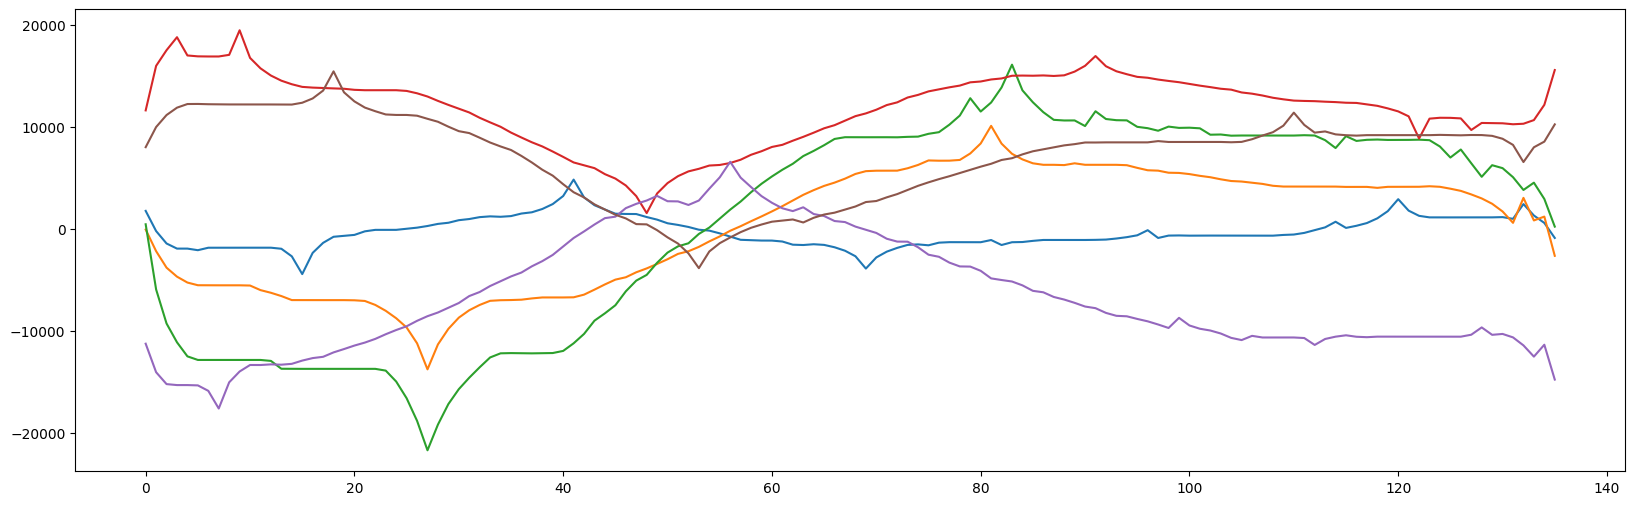

In [2]:
import matplotlib.pyplot as plt
for label,centroid_type in centroids.items():
    plt.figure(figsize=(20, 6))
    for centroid in centroid_type:
        plt.plot(centroid.ravel())
    print(label)
    plt.show()

In [3]:
from MotionRecognition.MotionRecognition import MotionRecognitionDTW

mr_dtw = MotionRecognitionDTW(centroids=list(centroids.values()))

def most_repeated_value(arr):
    counts = {}
    for num in arr:
        if num in counts:
            counts[num] += 1
        else:
            counts[num] = 1
    
    # Find the element with the maximum count
    most_common_element = max(counts, key=counts.get)
    
    return most_common_element

In [4]:

results = {}
for test,test_res in test_data:
    results[test_res] = results.get(test_res,[])
    mr_dtw.slide_window(test)
    res = mr_dtw.cmpr()
    results[test_res].append(most_repeated_value([np.argmin(r) for r in res]))

In [5]:
print(results)

{'bicep-curl-right': [0, 0, 0, 0, 0, 0], 'shoulder-fly-r': [1, 1, 1, 1, 1, 1, 1]}


# "Live" test

In [5]:
from MotionRecognition.tools import generate_centroids
import json
import numpy as np
interpolation_size = 140

centroids = {}
centroids_file = "/home/guiso/code/gymTracker/python/centroids.json"


In [6]:
# takes a long time
centroids = generate_centroids()


In [3]:

with open(centroids_file,"w") as f:
    json_serialized_centroids = {}
    
    for label,centroid_type in centroids.items():
        json_serialized_centroids[label] = []
        for stream in centroid_type:
            json_serialized_centroids[label].append(stream.ravel().tolist())
    json.dump(json_serialized_centroids,f)

In [7]:
with open(centroids_file,"r") as f:
    json_serialized_centroids = json.load(f)

numpy_centroids = {}

for label,centroid_type in json_serialized_centroids.items():
    numpy_centroids[label] = np.array(centroid_type).reshape(6,1,-1,1)


In [18]:
from Tracker.Motion import Motion 
import matplotlib.pyplot as plt

recorded_motion = Motion.from_file("/home/guiso/code/gymTracker/python/src/test2")

In [19]:
from MotionRecognition.MotionRecognition import MotionRecognitionDTW

mr_dtw = MotionRecognitionDTW(centroids=list(centroids.values()),sliding_window_size=300)

def most_repeated_value(arr):
    counts = {}
    for num in arr:
        if num in counts:
            counts[num] += 1
        else:
            counts[num] = 1
    
    # Find the element with the maximum count
    most_common_element = max(counts, key=counts.get)
    
    return most_common_element

In [24]:
results = [[[] for _ in range(mr_dtw.nb_streams)]  for _ in range(len(mr_dtw.centroids))]
for packet in recorded_motion.packets:
    for i in range(packet.nb_readings):
        mr_dtw.slide_window(packet.readings[:,i].reshape(-1,1))
        res = mr_dtw.cmpr()
        for j  in range(mr_dtw.nb_streams):
            for i in range(len(mr_dtw.centroids)):
                results[i][j].append(res[j][i])

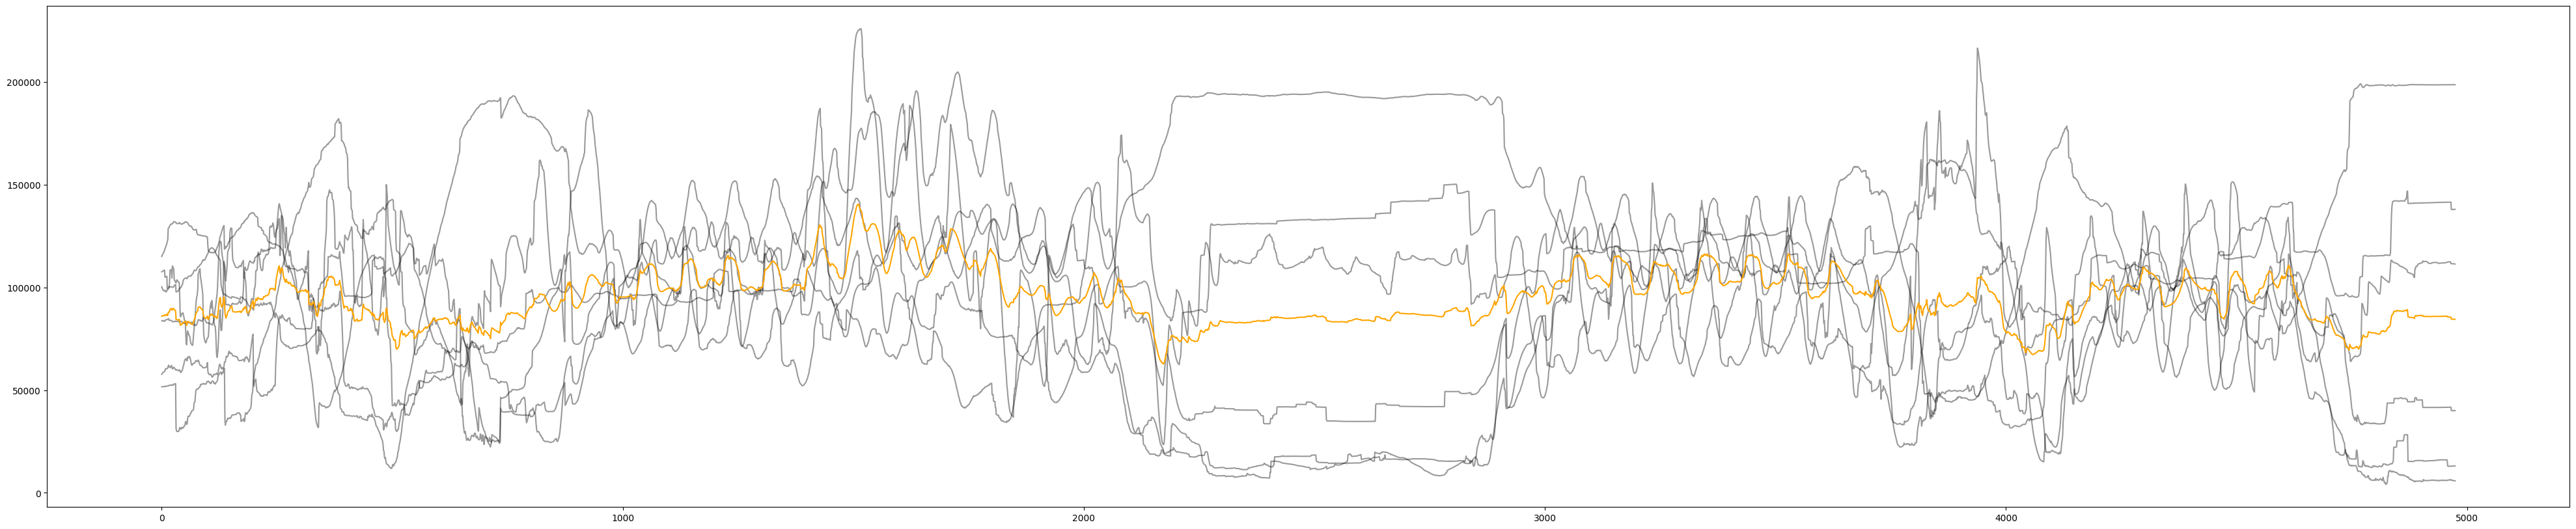

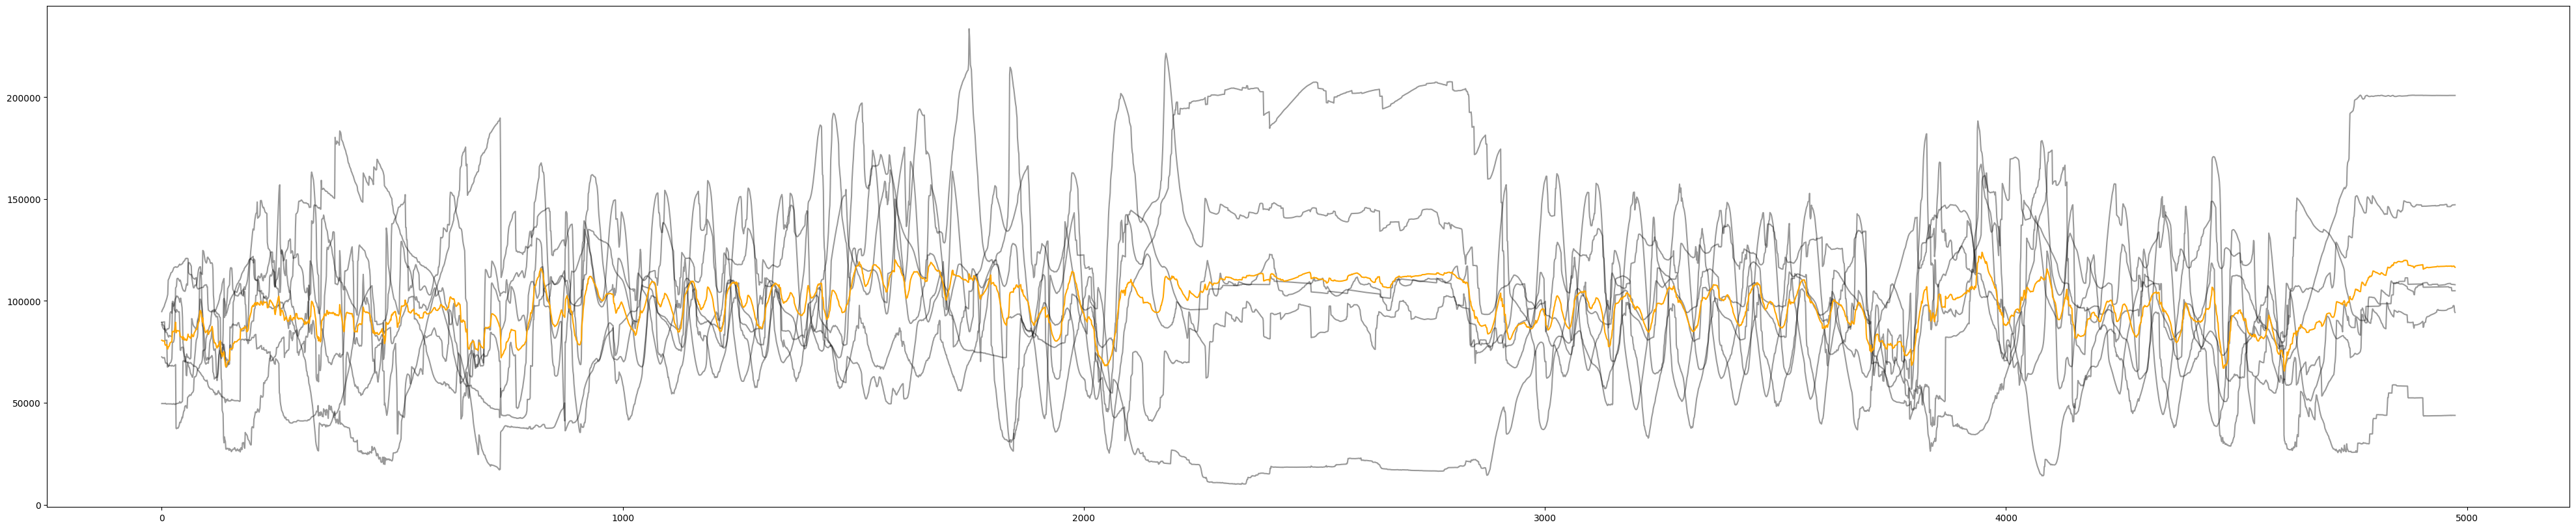

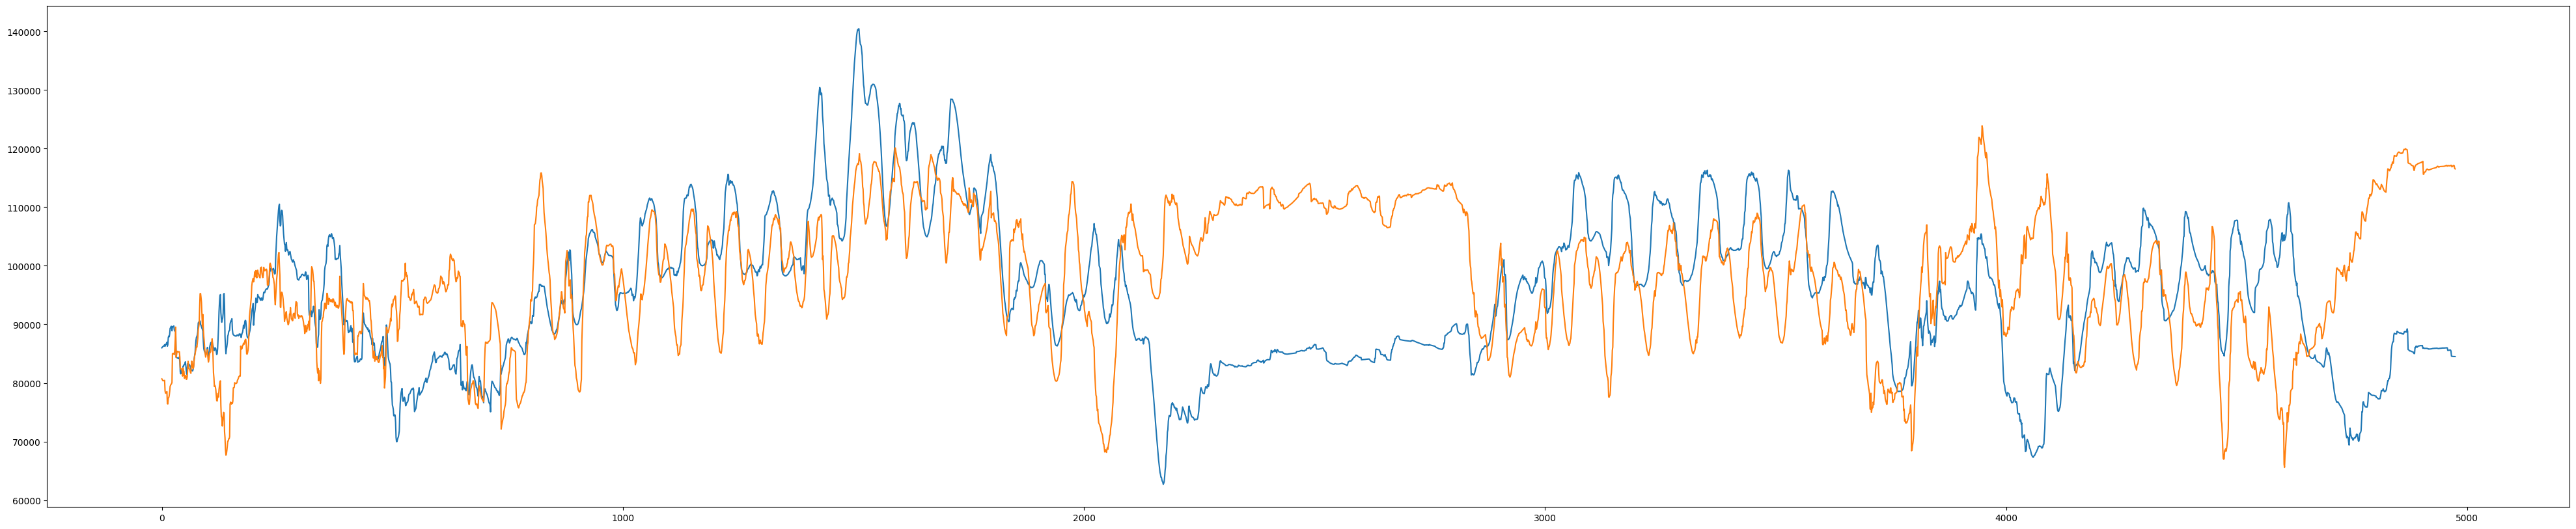

In [37]:
import matplotlib.pyplot as plt

for result_type in results:
    plt.figure(figsize=(50, 10))

    for stream in result_type:
        plt.plot(stream, color="000000",alpha=.4)
    
    np_result_type = np.array(result_type)
    plt.plot(sum(np_result_type)/6,color="#FFA500")

    plt.show()

plt.figure(figsize=(50, 10))

for result_type in results:
    np_result_type = np.array(result_type)
    plt.plot(sum(np_result_type)/6)

plt.show()

In [2]:
from MotionRecognition.tools import load_data, preprocess
from tslearn.barycenters.dba import dtw_barycenter_averaging

import numpy as np
interpolation_size = 140
data = load_data(preprocess=preprocess, interpolation_size=interpolation_size)
test_data = [
]

for key, streams in data.items():
    for i in range(65, len(streams[0])):
        curr_streams = [streams[j][i] for j in range(6)]
        test_data.append((np.array(curr_streams), key))

centroids = {}

for i in range(6):
    for key, stream in data.items():
        centroids[key] = centroids.get(key, [[], [], [], [], [], []])
        centroids[key][i] = dtw_barycenter_averaging(stream[i][:65])

In [8]:
for key, value in centroids.items():
    print(len(value))

6
6


In [10]:
from MotionRecognition.MotionRecognition import MotionRecognitionDTW

mr_dtw = MotionRecognitionDTW(centroids=list(centroids.values()),sliding_window_size=300)

def most_repeated_value(arr):
    counts = {}
    for num in arr:
        if num in counts:
            counts[num] += 1
        else:
            counts[num] = 1
    
    # Find the element with the maximum count
    most_common_element = max(counts, key=counts.get)
    
    return most_common_element

In [9]:
from Tracker.Motion import Motion 
import matplotlib.pyplot as plt

recorded_motion = Motion.from_file("/home/guiso/code/gymTracker/python/src/test2")

In [30]:
from MotionRecognition.tools import load_data, preprocess
from tslearn.barycenters.dba import dtw_barycenter_averaging
from scipy.interpolate import interp1d
def preprocess_signal(s,m=150):
    '''Preprocesses the signal'''

    # TODO: write your preprocessing code here. We'll do something very simple for now,
    # which is just a mean filter of window size 5. But you'll need to do more!
    # For exampling, explore detrending and diff filtering algs (with different window sizes)

    mean_filter_window_size = 5
    processed_signal = np.convolve(s,
                                   np.ones((mean_filter_window_size,)) /
                                   mean_filter_window_size,
                                   mode='valid')
    if len(processed_signal) < m:
        f = interp1d(np.linspace(0, 1, len(processed_signal)), processed_signal, kind='linear')
        interpolated_stream = f(np.linspace(0, 1, m))
    else:
        interpolated_stream = processed_signal[:m]
    return interpolated_stream

data_preprocessed = load_data(preprocess=preprocess_signal)


In [58]:
centroids = {}
for label,motion in data_preprocessed.items():
    centroids[label] = []
    for stream in motion:
        centroids[label].extend([s for s in dtw_barycenter_averaging(stream,barycenter_size=150).reshape((5,-1))])

In [48]:
from MotionRecognition.MotionRecognition import MotionRecognitionDTW

mr_dtw = MotionRecognitionDTW(centroids=list(centroids.values()),sliding_window_size=30,divided=5)

In [ ]:
def cmpr():
    

In [49]:
results = [[[] for _ in range(mr_dtw.nb_streams)]  for _ in range(len(mr_dtw.centroids))]
for packet in recorded_motion.packets:
    for i in range(packet.nb_readings):
        mr_dtw.slide_window(packet.readings[:,i].reshape(-1,1))
        res = mr_dtw.cmpr()
        for j  in range(mr_dtw.nb_streams):
            for i in range(len(mr_dtw.centroids)):
                results[i][j].append(res[j][i])

In [55]:
print(len(results))
print(len(results[0]))
print(len(results[0][0]))
print(results[0][0][0])




2
6
4975
12839.038729533508
